## FLAML for hp optimisation and model selection
We use FLAML twice, first to find the best component model for each estimator, and then to optimise the estimators themselves and choose the best estimator. Here we show how it's done

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
# warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now.. 

# the below checks for whether we run dowhy and auto-causality from source
root_path = root_path = os.path.realpath('../..')
try: 
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))
    
try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

In [2]:
from auto_causality import AutoCausality
from auto_causality.datasets import synth_ihdp, preprocess_dataset
from auto_causality.scoring import ate

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the ERUPT metric on held-out data

In [ ]:
# import dataset
data_df = synth_ihdp()
data_df, features_X, features_W, targets, treatment = preprocess_dataset(data_df)
outcome = targets[0]


# init autocausality object with chosen metric to optimise
ac = AutoCausality(
    time_budget=1800, 
    estimator_list=[
            "Dummy",
            "SparseLinearDML",
            "ForestDRLearner",
            "TransformedOutcome",
            "CausalForestDML",
            ".LinearDML",
            "DomainAdaptationLearner",
            "SLearner",
            "XLearner",
            "TLearner",
            # "Ortho",
        ],#"auto", 
    metric="norm_erupt", 
    verbose=3,
    components_verbose=2,
    components_time_budget=30,
)

# run autocausality
myresults = ac.fit(data_df, treatment, outcome, features_W, features_X)

# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")


In [9]:
# outcome = targets[0]
# ac.scores.pop("baseline", None)
# baseline_scores={"estimator": "baseline",
#                                "outcome": outcome, "scores":{
#                               "train":{"erupt": ac.train_df[outcome].mean(),
#                                        "ate": ate(ac.train_df[treatment],ac.train_df[outcome])[0]},
#                               "validation":{"erupt": ac.test_df[outcome].mean(),
#                                       "ate": ate(ac.test_df[treatment],ac.test_df[outcome])[0]}}}
# ac.scores = {"baseline": baseline_scores, **ac.scores}

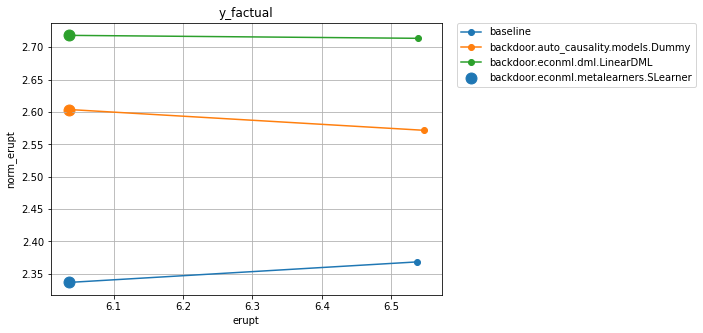

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "erupt"
m2 = "norm_erupt"

for (est, scr), col in zip(ac.scores.items(),colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1]]
        crv = [scr["scores"]['train'][m2], scr["scores"]['validation'][m2]]
        plt.plot(sc, crv, color=col, marker="o")
        plt.scatter(sc[1:],crv[1:], c=col, s=120 )
    except:
        pass
plt.xlabel(m1)
plt.ylabel(m2)

plt.legend(ac.scores.keys(),bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


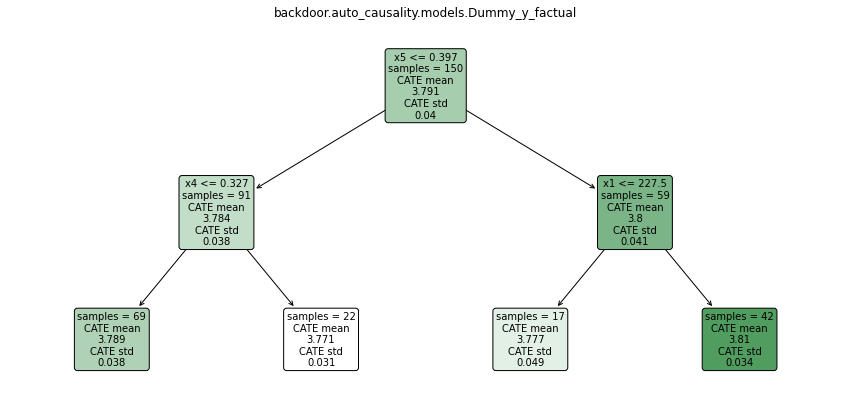

In [6]:
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
try: 
    feature_names = intrp.feature_names
except:
    feature_names = features_X + [ w for w in features_W if w not in features_X]
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
#         intrp.plot( fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()


In [7]:
# TODO: add SHAP plots!
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = ac.test_df.sample(100)


scr = ac.scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()


y_factual backdoor.auto_causality.models.Dummy

'Dummy' object has no attribute 'shap_values'


AttributeError: 'DummyModel' object has no attribute 'shap_values'